In [87]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10, CelebA
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
BATCH_SIZE = 8
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=2)

In [5]:
classes = {i:name for i, name in enumerate(trainset.classes)}
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
imgs, labels = next(iter(trainloader))

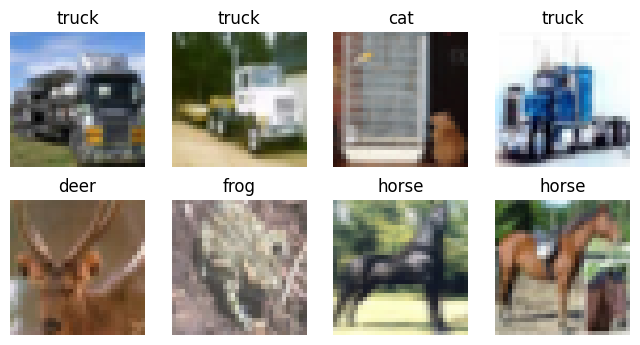

In [7]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

show_imgs(imgs, labels)

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.ConvTranspose2d(in_channels=latent_dim, 
                               out_channels=256,
                               kernel_size=4, 
                               stride=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128,
                               kernel_size=4, 
                               stride=2, 
                               padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64,
                               kernel_size=4, 
                               stride=2, 
                               padding=1, bias=False), 
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=3,
                               kernel_size=4,
                               stride=2, 
                               padding=1, bias=False))
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [84]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten(),
            nn.Sigmoid())
        
    def forward(self, input, labels):
        embds = self.embeddings(labels).view(input.shape)
        concat = torch.cat((input, embds), dim=1)
        return self.model(concat)

In [51]:
class ModelConfig:
    def __init__(self, batch_size, epochs, classes):
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.CLASSES = classes

In [94]:
class CGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(CGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_optimizer, g_loss,
                      d_optimizer, d_loss):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss 
        self.d_loss = d_loss
    
    def forward(self, labels):
        with torch.inference_mode():
            out = self.generator(labels)
        return out.detach()

In [100]:
def train_step(model: nn.Module, trainloader: DataLoader,
               device: torch.device, metric: callable):
    
    for real_imgs, labels in tqdm(trainloader):
        ones = torch.ones_like(labels)
        zeros = torch.zeros_like(labels)
        
        fake_imgs = model.generator(labels)
        # d_fake = model.discriminator()
        
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, metric: callable=None):
    ...

LATENT_DIM = 100

generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

g_loss = nn.BCELoss()
d_loss = nn.BCELoss()

cgan = CGAN(generator, discriminator)
cgan.compile(g_optimizer, g_loss, 
             d_optimizer, d_loss)

device = 'xpu' if ipex.xpu.is_available() else 'cpu'

train(cgan, trainloader, testloader, device)